In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ultralytics tqdm pyyaml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
import os
import shutil
import random
from ultralytics import YOLO
import yaml
from tqdm import tqdm

# ===== CONFIG =====
DATASET_PATH = '/content/drive/MyDrive/Plastic Bottle Dataset'  # Your normal images and labels
CRUSHED_IMAGES_PATH = '/content/drive/MyDrive/Crushed'  # Your crushed images with NO labels
TEMP_PATH = 'temp_crushed_split'
AREA_THRESHOLD = 0.02  # Area threshold for pseudo-labeling
SPLIT_RATIO = [0.7, 0.2, 0.1]  # train/val/test split for crushed images
IMAGE_SIZE = 640
DEVICE = 'cuda'  # or 'cpu'


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# ===== PREPARE DATA.YAML =====
def prepare_data_yaml():
    data_yaml = {
        'train': os.path.join(DATASET_PATH, 'images', 'train'),
        'val': os.path.join(DATASET_PATH, 'images', 'val'),
        'test': os.path.join(DATASET_PATH, 'images', 'test'),
        'nc': 3,
        'names': ['bottle', 'crushed_bottle', 'non_bottle']
    }
    with open(os.path.join(DATASET_PATH, 'data.yaml'), 'w') as f:
        yaml.dump(data_yaml, f)
    print("✅ data.yaml prepared.")


In [ ]:
# ===== TRAIN MODEL =====
import torch

def train_model():
    model = YOLO('yolov8n.pt')
    model.train(
        data=os.path.join(DATASET_PATH, 'data.yaml'),
        imgsz=IMAGE_SIZE,
        batch=16,
        epochs=50,
        device ='cuda'

    )
    print("✅ Model trained with normal bottles.")

In [ ]:
# ===== SPLIT CRUSHED IMAGES =====
def split_crushed_images():
    images = [f for f in os.listdir(CRUSHED_IMAGES_PATH) if f.endswith(('.jpg', '.png'))]
    random.shuffle(images)

    train_cut = int(len(images) * SPLIT_RATIO[0])
    val_cut = int(len(images) * (SPLIT_RATIO[0] + SPLIT_RATIO[1]))

    split = {
        'train': images[:train_cut],
        'val': images[train_cut:val_cut],
        'test': images[val_cut:]
    }

    for split_name, files in split.items():
        img_split_path = os.path.join(TEMP_PATH, 'images', split_name)
        lbl_split_path = os.path.join(TEMP_PATH, 'labels', split_name)
        os.makedirs(img_split_path, exist_ok=True)
        os.makedirs(lbl_split_path, exist_ok=True)

        for img_file in tqdm(files, desc=f"Copying {split_name} images", unit="file"):
            shutil.copy(os.path.join(CRUSHED_IMAGES_PATH, img_file), img_split_path)

    print("✅ Crushed images split into train/val/test.")

In [ ]:
# ===== PSEUDO-LABEL CRUSHED IMAGES =====
def pseudo_label_crushed_images():
    model = YOLO('runs/detect/train/weights/best.pt')  # load your trained model
    all_split_paths = ['train', 'val', 'test']

    for split in all_split_paths:
        img_folder = os.path.join(TEMP_PATH, 'images', split)
        lbl_folder = os.path.join(TEMP_PATH, 'labels', split)

        results = model.predict(source=img_folder, save_txt=False, save_conf=True, imgsz=IMAGE_SIZE, conf=0.5, device=DEVICE)

        for result in tqdm(results, desc=f"Processing {split} images", unit="file"):
            img_path = result.path
            img_name = os.path.basename(img_path)

            w, h = result.orig_shape[1], result.orig_shape[0]
            label_path = os.path.join(lbl_folder, img_name.replace('.jpg', '.txt').replace('.png', '.txt'))

            with open(label_path, 'w') as f:
                for box in result.boxes.xywhn:
                    x, y, bw, bh = box.tolist()
                    area = bw * bh

                    # Define which class the object belongs to
                    if area < AREA_THRESHOLD:
                        class_id = 1  # crushed bottle
                    elif area >= AREA_THRESHOLD:
                        class_id = 0  # bottle
                    else:
                        class_id = 2  # non_bottle

                    f.write(f"{class_id} {x} {y} {bw} {bh}\n")

    print("✅ Pseudo-labels generated.")

In [ ]:
# ===== MERGE CRUSHED DATA INTO MAIN DATASET =====
def merge_crushed_into_main_dataset():
    all_split_paths = ['train', 'val', 'test']

    for split in all_split_paths:
        crushed_imgs = os.listdir(os.path.join(TEMP_PATH, 'images', split))

        for img_file in tqdm(crushed_imgs, desc=f"Merging {split} images", unit="file"):
            shutil.move(
                os.path.join(TEMP_PATH, 'images', split, img_file),
                os.path.join(DATASET_PATH, 'images', split, img_file)
            )

            lbl_file = img_file.replace('.jpg', '.txt').replace('.png', '.txt')
            shutil.move(
                os.path.join(TEMP_PATH, 'labels', split, lbl_file),
                os.path.join(DATASET_PATH, 'labels', split, lbl_file)
            )

    print("✅ Crushed data merged into main dataset.")

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


# import torch
# print(torch.cuda.is_available())  # Should return True if GPU is available
# print(torch.cuda.get_device_name(0))  # Should print the GPU model name


Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:

# ===== MAIN PIPELINE =====
if __name__ == "__main__":
    # 1. Prepare data.yaml
    prepare_data_yaml()

    # 2. Train on normal bottles
    train_model()

    # 3. Split crushed images
    split_crushed_images()

    # 4. Pseudo-label crushed images
    pseudo_label_crushed_images()

    # 5. Merge crushed into main dataset
    merge_crushed_into_main_dataset()

    print("🚀 Full pipeline complete. You can now retrain the model including crushed bottles!")



✅ data.yaml prepared.


100%|██████████| 6.25M/6.25M [00:00<00:00, 75.0MB/s]


Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/Plastic Bottle Dataset/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True,

100%|██████████| 755k/755k [00:00<00:00, 15.2MB/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,433 parameters, 3,011,417 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 67.6MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 1.0±0.9 ms, read: 1.4±1.7 MB/s, size: 452.2 KB)


train: Scanning /content/drive/MyDrive/Plastic Bottle Dataset/labels/train.cache... 2172 images, 5 backgrounds, 2 corrupt: 100%|██████████| 2177/2177 [00:00<?, ?it/s]

train: /content/drive/MyDrive/Plastic Bottle Dataset/images/train/image_png.rf.1a276c55e373ab8b9f54b8edc3ef2b1d.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0044       1.018      1.0129]
train: /content/drive/MyDrive/Plastic Bottle Dataset/images/train/water-bottles_jpg.rf.7f2cf644e7b419c297daade95476a192.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0113]
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 134, len(boxes) = 3174. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.5±0.2 ms, read: 3.3±3.3 MB/s, size: 699.0 KB)


val: Scanning /content/drive/MyDrive/Plastic Bottle Dataset/labels/val.cache... 1163 images, 11 backgrounds, 0 corrupt: 100%|██████████| 1174/1174 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 46, len(boxes) = 1533. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.02G      1.503      2.269      1.669         49        640: 100%|██████████| 136/136 [08:17<00:00,  3.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [01:02<00:00,  1.68s/it]


                   all       1174       1533      0.536      0.426      0.349      0.193

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.54G      1.548      1.908       1.67         33        640: 100%|██████████| 136/136 [01:07<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:54<00:00,  1.48s/it]


                   all       1174       1533      0.432      0.419      0.263      0.143

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.55G      1.613      1.825      1.724         43        640: 100%|██████████| 136/136 [01:07<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:57<00:00,  1.55s/it]


                   all       1174       1533      0.394      0.384      0.237      0.123

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.55G      1.612      1.738      1.701         71        640: 100%|██████████| 136/136 [01:06<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:54<00:00,  1.47s/it]

                   all       1174       1533      0.493      0.398      0.338      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.55G      1.575      1.674      1.674         43        640: 100%|██████████| 136/136 [01:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:57<00:00,  1.57s/it]


                   all       1174       1533      0.447      0.338      0.287       0.16

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.55G      1.514      1.603      1.635         36        640: 100%|██████████| 136/136 [01:06<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:54<00:00,  1.47s/it]


                   all       1174       1533      0.541      0.434      0.369      0.226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.55G      1.511      1.582      1.635         55        640: 100%|██████████| 136/136 [01:05<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:53<00:00,  1.45s/it]


                   all       1174       1533      0.546      0.485      0.377      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.55G      1.506      1.588      1.622         42        640: 100%|██████████| 136/136 [01:06<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:54<00:00,  1.47s/it]


                   all       1174       1533      0.562      0.466      0.414      0.256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.55G      1.476      1.535      1.605         35        640: 100%|██████████| 136/136 [01:06<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:55<00:00,  1.50s/it]


                   all       1174       1533      0.524      0.507      0.369      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.55G      1.444      1.543      1.589         45        640: 100%|██████████| 136/136 [01:06<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:55<00:00,  1.50s/it]

                   all       1174       1533      0.509      0.508      0.369      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.55G       1.43      1.507      1.588         43        640: 100%|██████████| 136/136 [01:05<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:54<00:00,  1.47s/it]

                   all       1174       1533      0.544      0.519      0.407      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.55G      1.389      1.424      1.535         45        640: 100%|██████████| 136/136 [01:06<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:54<00:00,  1.46s/it]

                   all       1174       1533      0.623      0.478      0.431      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.55G      1.396      1.453      1.543         68        640: 100%|██████████| 136/136 [01:06<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:53<00:00,  1.45s/it]

                   all       1174       1533      0.532      0.519      0.347      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.55G      1.362      1.424      1.527         67        640: 100%|██████████| 136/136 [01:04<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:53<00:00,  1.43s/it]

                   all       1174       1533      0.567      0.525      0.367      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.55G      1.365      1.438       1.52         41        640: 100%|██████████| 136/136 [01:05<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:54<00:00,  1.47s/it]


                   all       1174       1533      0.636      0.457       0.41      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.55G      1.307      1.351       1.49         46        640: 100%|██████████| 136/136 [01:05<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:53<00:00,  1.44s/it]

                   all       1174       1533      0.583       0.52      0.423      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.56G      1.325      1.365      1.489         45        640: 100%|██████████| 136/136 [01:05<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:54<00:00,  1.46s/it]


                   all       1174       1533      0.575      0.526      0.377      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.58G        1.3      1.331      1.476         41        640: 100%|██████████| 136/136 [01:05<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:54<00:00,  1.46s/it]

                   all       1174       1533      0.589      0.538      0.419      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50       2.6G      1.292      1.311      1.479         40        640: 100%|██████████| 136/136 [01:04<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:53<00:00,  1.46s/it]

                   all       1174       1533      0.583      0.532      0.382      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       2.6G      1.314      1.402      1.492         54        640: 100%|██████████| 136/136 [01:05<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:54<00:00,  1.46s/it]

                   all       1174       1533      0.582      0.539      0.432      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       2.6G      1.276      1.334       1.46         39        640: 100%|██████████| 136/136 [01:05<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:53<00:00,  1.44s/it]


                   all       1174       1533      0.683      0.469      0.441      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       2.6G      1.281       1.32      1.462         50        640: 100%|██████████| 136/136 [01:04<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:53<00:00,  1.45s/it]

                   all       1174       1533      0.569      0.512      0.375      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       2.6G      1.246      1.259      1.426         43        640: 100%|██████████| 136/136 [01:05<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:53<00:00,  1.44s/it]

                   all       1174       1533      0.573      0.537       0.38      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50       2.6G      1.249      1.278       1.44         52        640: 100%|██████████| 136/136 [01:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:55<00:00,  1.50s/it]


                   all       1174       1533      0.641      0.503      0.437      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       2.6G      1.227      1.274      1.431         58        640: 100%|██████████| 136/136 [01:05<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:54<00:00,  1.47s/it]

                   all       1174       1533      0.606      0.496      0.422      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       2.6G      1.227      1.271       1.43         44        640: 100%|██████████| 136/136 [01:06<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:52<00:00,  1.43s/it]


                   all       1174       1533      0.649      0.494      0.468      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       2.6G      1.236      1.266      1.434         48        640: 100%|██████████| 136/136 [01:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:53<00:00,  1.45s/it]


                   all       1174       1533      0.574      0.559      0.399      0.256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       2.6G      1.198      1.227      1.411         38        640: 100%|██████████| 136/136 [01:06<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:53<00:00,  1.46s/it]

                   all       1174       1533      0.563      0.543      0.374      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       2.6G      1.173       1.22      1.389         32        640: 100%|██████████| 136/136 [01:05<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:53<00:00,  1.45s/it]


                   all       1174       1533      0.578      0.507      0.412       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       2.6G      1.179      1.189      1.388         55        640: 100%|██████████| 136/136 [01:04<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:53<00:00,  1.44s/it]

                   all       1174       1533      0.594      0.539      0.433      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       2.6G      1.202      1.242      1.413         38        640: 100%|██████████| 136/136 [01:05<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:53<00:00,  1.46s/it]

                   all       1174       1533      0.611      0.524      0.465      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       2.6G      1.195        1.2       1.39         40        640: 100%|██████████| 136/136 [01:04<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:53<00:00,  1.44s/it]

                   all       1174       1533      0.645      0.517      0.478      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       2.6G      1.167      1.204      1.386         49        640: 100%|██████████| 136/136 [01:05<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:53<00:00,  1.45s/it]

                   all       1174       1533      0.594      0.524      0.434      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       2.6G      1.158      1.171      1.376         45        640: 100%|██████████| 136/136 [01:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:53<00:00,  1.46s/it]

                   all       1174       1533      0.602      0.539      0.438      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       2.6G      1.145      1.147      1.374         59        640: 100%|██████████| 136/136 [01:05<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:53<00:00,  1.45s/it]

                   all       1174       1533      0.633        0.5      0.444      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       2.6G      1.152      1.179       1.37         32        640: 100%|██████████| 136/136 [01:05<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:52<00:00,  1.42s/it]

                   all       1174       1533       0.59      0.543      0.398      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       2.6G      1.154      1.168      1.379         49        640: 100%|██████████| 136/136 [01:04<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:53<00:00,  1.45s/it]

                   all       1174       1533      0.585      0.542      0.416      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       2.6G      1.142      1.157      1.363         46        640: 100%|██████████| 136/136 [01:04<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:52<00:00,  1.42s/it]


                   all       1174       1533      0.647      0.526      0.484      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       2.6G      1.113      1.128      1.352         39        640: 100%|██████████| 136/136 [01:04<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:53<00:00,  1.45s/it]

                   all       1174       1533      0.593      0.542      0.425      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       2.6G      1.104      1.119      1.355         43        640: 100%|██████████| 136/136 [01:06<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:54<00:00,  1.49s/it]

                   all       1174       1533      0.597      0.554      0.445        0.3


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       2.6G      1.078       1.09      1.358         15        640: 100%|██████████| 136/136 [01:09<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:53<00:00,  1.44s/it]


                   all       1174       1533      0.654      0.492      0.476      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       2.6G       1.06       1.04      1.334         16        640: 100%|██████████| 136/136 [01:07<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:52<00:00,  1.42s/it]


                   all       1174       1533      0.587      0.561      0.446      0.304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       2.6G      1.047      1.027      1.329         23        640: 100%|██████████| 136/136 [01:07<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:54<00:00,  1.47s/it]

                   all       1174       1533      0.605      0.514      0.458      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       2.6G      1.029      1.013      1.319         20        640: 100%|██████████| 136/136 [01:05<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:53<00:00,  1.45s/it]

                   all       1174       1533      0.686       0.49      0.501      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       2.6G       1.03      1.002      1.323         16        640: 100%|██████████| 136/136 [01:05<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:54<00:00,  1.46s/it]

                   all       1174       1533       0.64      0.522      0.491      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       2.6G      1.011     0.9829      1.318         18        640: 100%|██████████| 136/136 [01:09<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:55<00:00,  1.51s/it]

                   all       1174       1533      0.597      0.553      0.473      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50       2.6G          1     0.9694      1.299         17        640: 100%|██████████| 136/136 [01:08<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:55<00:00,  1.49s/it]

                   all       1174       1533      0.606      0.543      0.463      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       2.6G     0.9852     0.9563      1.299         15        640: 100%|██████████| 136/136 [01:06<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:54<00:00,  1.47s/it]

                   all       1174       1533      0.599      0.561      0.472      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       2.6G     0.9782     0.9403      1.276         18        640: 100%|██████████| 136/136 [01:05<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:54<00:00,  1.47s/it]

                   all       1174       1533      0.606      0.534      0.482      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       2.6G     0.9632     0.9271      1.275         23        640: 100%|██████████| 136/136 [01:06<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:55<00:00,  1.50s/it]

                   all       1174       1533      0.604      0.535       0.47      0.319



50 epochs completed in 1.803 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:57<00:00,  1.57s/it]


                   all       1174       1533      0.693      0.489      0.501      0.343
                bottle       1163       1533      0.693      0.489      0.501      0.343
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/detect/train
✅ Model trained with normal bottles.


Copying test images: 100%|██████████| 81/81 [00:00<00:00, 428.52file/s]


✅ Crushed images split into train/val/test.

image 1/560 /content/temp_crushed_split/images/train/abcku.jpg: 480x640 (no detections), 45.7ms
image 2/560 /content/temp_crushed_split/images/train/abjgk.jpg: 480x640 (no detections), 8.4ms
image 3/560 /content/temp_crushed_split/images/train/ablig.jpg: 480x640 1 bottle, 6.5ms
image 4/560 /content/temp_crushed_split/images/train/abtfi.jpg: 480x640 1 bottle, 6.5ms
image 5/560 /content/temp_crushed_split/images/train/abwiq.jpg: 480x640 (no detections), 8.3ms
image 6/560 /content/temp_crushed_split/images/train/abwtn.jpg: 480x640 1 bottle, 6.4ms
image 7/560 /content/temp_crushed_split/images/train/abywq.jpg: 480x640 1 bottle, 6.5ms
image 8/560 /content/temp_crushed_split/images/train/acdbs.jpg: 480x640 1 bottle, 10.3ms
image 9/560 /content/temp_crushed_split/images/train/achnp.jpg: 480x640 1 bottle, 6.6ms
image 10/560 /content/temp_crushed_split/images/train/acorb.jpg: 480x640 1 bottle, 6.5ms
image 11/560 /content/temp_crushed_split/images/tra

Processing train images: 100%|██████████| 560/560 [00:00<00:00, 1754.80file/s]


image 1/159 /content/temp_crushed_split/images/val/abwze.jpg: 480x640 1 bottle, 7.5ms
image 2/159 /content/temp_crushed_split/images/val/abyqx.jpg: 480x640 1 bottle, 6.7ms
image 3/159 /content/temp_crushed_split/images/val/adunj.jpg: 480x640 (no detections), 6.2ms
image 4/159 /content/temp_crushed_split/images/val/aerjp.jpg: 480x640 (no detections), 10.1ms
image 5/159 /content/temp_crushed_split/images/val/aerxs.jpg: 480x640 1 bottle, 6.4ms
image 6/159 /content/temp_crushed_split/images/val/aeunf.jpg: 480x640 (no detections), 6.4ms
image 7/159 /content/temp_crushed_split/images/val/afbns.jpg: 480x640 1 bottle, 6.2ms


image 8/159 /content/temp_crushed_split/images/val/agcki.jpg: 480x640 1 bottle, 9.1ms
image 9/159 /content/temp_crushed_split/images/val/agubs.jpg: 480x640 (no detections), 6.5ms
image 10/159 /content/temp_crushed_split/images/val/agurp.jpg: 480x640 (no detections), 7.2ms
image 11/159 /content/temp_crushed_split/images/val/agxsz.jpg: 480x640 1 bottle, 6.4ms
image 12/159 /content/temp_crushed_split/images/val/ahdgs.jpg: 480x640 (no detections), 6.2ms
image 13/159 /content/temp_crushed_split/images/val/aijwn.jpg: 480x640 1 bottle, 6.1ms
image 14/159 /content/temp_crushed_split/images/val/ailqk.jpg: 480x640 1 bottle, 6.8ms
image 15/159 /content/temp_crushed_split/images/val/ailwe.jpg: 480x640 (no detections), 6.7ms
image 16/159 /content/temp_crushed_split/images/val/aioet.jpg: 480x640 1 bottle, 8.2ms
image 17/159 /content/temp_crushed_split/images/val/airgu.jpg: 480x640 1 bottle, 6.3ms
image 18/159 /content/temp_crushed_split/images/val/aiymk.jpg: 480x640 (no detections), 8.1ms
image 19/1

Processing val images: 100%|██████████| 159/159 [00:00<00:00, 1804.80file/s]


image 1/81 /content/temp_crushed_split/images/test/abhno.jpg: 480x640 (no detections), 7.9ms
image 2/81 /content/temp_crushed_split/images/test/ablco.jpg: 480x640 (no detections), 9.1ms
image 3/81 /content/temp_crushed_split/images/test/acrfu.jpg: 480x640 1 bottle, 6.7ms
image 4/81 /content/temp_crushed_split/images/test/ajblm.jpg: 480x640 1 bottle, 6.4ms
image 5/81 /content/temp_crushed_split/images/test/ajqkv.jpg: 480x640 (no detections), 6.7ms
image 6/81 /content/temp_crushed_split/images/test/ajvdm.jpg: 480x640 1 bottle, 11.7ms
image 7/81 /content/temp_crushed_split/images/test/akcfy.jpg: 480x640 1 bottle, 6.9ms
image 8/81 /content/temp_crushed_split/images/test/akrjo.jpg: 480x640 (no detections), 6.5ms


image 9/81 /content/temp_crushed_split/images/test/alisy.jpg: 480x640 (no detections), 8.1ms
image 10/81 /content/temp_crushed_split/images/test/alywd.jpg: 480x640 1 bottle, 8.5ms
image 11/81 /content/temp_crushed_split/images/test/amcip.jpg: 480x640 1 bottle, 7.0ms
image 12/81 /content/temp_crushed_split/images/test/amezr.jpg: 480x640 (no detections), 6.8ms
image 13/81 /content/temp_crushed_split/images/test/amzcs.jpg: 480x640 1 bottle, 9.5ms
image 14/81 /content/temp_crushed_split/images/test/anxig.jpg: 480x640 (no detections), 6.5ms
image 15/81 /content/temp_crushed_split/images/test/apkre.jpg: 480x640 1 bottle, 10.1ms
image 16/81 /content/temp_crushed_split/images/test/aqitv.jpg: 480x640 1 bottle, 7.1ms
image 17/81 /content/temp_crushed_split/images/test/arled.jpg: 480x640 1 bottle, 6.3ms
image 18/81 /content/temp_crushed_split/images/test/arnfl.jpg: 480x640 (no detections), 8.1ms
image 19/81 /content/temp_crushed_split/images/test/arnsu.jpg: 480x640 (no detections), 6.3ms
image 20

Processing test images: 100%|██████████| 81/81 [00:00<00:00, 1132.48file/s]


✅ Pseudo-labels generated.


Merging test images: 100%|██████████| 81/81 [00:01<00:00, 58.43file/s]

✅ Crushed data merged into main dataset.
🚀 Full pipeline complete. You can now retrain the model including crushed bottles!


In [ ]:
import os
import shutil
import random
from ultralytics import YOLO
import yaml
from tqdm import tqdm

DRIVE_PROJECT_PATH = '/content/drive/MyDrive/yolov8_training'  # Folder in Drive to save everything

def retrain_model():
    model = YOLO('yolov8n.pt')  # Load the pre-trained YOLOv8 model
    # Start training the model
    results = model.train(
        data=os.path.join(DATASET_PATH, 'data.yaml'),  # Path to the data.yaml file
        imgsz=IMAGE_SIZE,  # Image size
        batch=16,  # Batch size
        epochs=100,  # Number of epochs
        device="cuda",
        project=DRIVE_PROJECT_PATH,  # Save directly to Google Drive
        name='exp',  # Training run folder will be saved as yolov8_training/exp
    )

    # Best/final model saved in Drive already — you can copy it elsewhere in Drive if needed
    source_best_model = os.path.join(DRIVE_PROJECT_PATH, 'exp', 'weights', 'best.pt')
    source_final_model = os.path.join(DRIVE_PROJECT_PATH, 'exp', 'weights', 'last.pt')

    # Optional: Backup with simpler names in the root of MyDrive
    backup_best_model = '/content/drive/MyDrive/yolov8_best_model.pt'
    backup_final_model = '/content/drive/MyDrive/yolov8_final_model.pt'

    shutil.copy(source_best_model, backup_best_model)
    shutil.copy(source_final_model, backup_final_model)

    print("✅ Retraining complete with normal and crushed bottles.")
    print(f"✅ Best model saved to: /content/drive/MyDrive/yolov8_best_model.pt")
    print(f"✅ Final model saved to: /content/drive/MyDrive/yolov8_final_model.pt")

retrain_model()


100%|██████████| 6.25M/6.25M [00:00<00:00, 362MB/s]


Ultralytics 8.3.124 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/Plastic Bottle Dataset/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=/content/drive/MyDrive/yolov8_training, name=exp, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, 

100%|██████████| 755k/755k [00:00<00:00, 97.0MB/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,433 parameters, 3,011,417 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 130MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.5±0.2 ms, read: 0.5±0.6 MB/s, size: 514.6 KB)


train: Scanning /content/drive/MyDrive/Plastic Bottle Dataset/labels/train.cache... 2732 images, 239 backgrounds, 2 corrupt: 100%|██████████| 2737/2737 [00:00<?, ?it/s]

train: /content/drive/MyDrive/Plastic Bottle Dataset/images/train/image_png.rf.1a276c55e373ab8b9f54b8edc3ef2b1d.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0044       1.018      1.0129]
train: /content/drive/MyDrive/Plastic Bottle Dataset/images/train/water-bottles_jpg.rf.7f2cf644e7b419c297daade95476a192.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0113]
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 134, len(boxes) = 3500. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 1.1±0.6 MB/s, size: 971.3 KB)


val: Scanning /content/drive/MyDrive/Plastic Bottle Dataset/labels/val.cache... 1322 images, 68 backgrounds, 0 corrupt: 100%|██████████| 1333/1333 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 46, len(boxes) = 1635. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to /content/drive/MyDrive/yolov8_training/exp/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/yolov8_training/exp
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       2.1G      1.452      2.189      1.611         34        640: 100%|██████████| 171/171 [32:43<00:00, 11.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [01:20<00:00,  1.91s/it]


                   all       1333       1635      0.531      0.505      0.381      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.62G      1.504      1.782      1.629         43        640: 100%|██████████| 171/171 [01:28<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [01:02<00:00,  1.50s/it]


                   all       1333       1635      0.469      0.439      0.306      0.173

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.62G      1.587       1.76      1.691         42        640: 100%|██████████| 171/171 [01:28<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [01:04<00:00,  1.54s/it]


                   all       1333       1635       0.47      0.489      0.307      0.163

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.62G      1.594      1.712      1.691         38        640: 100%|██████████| 171/171 [01:25<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [01:00<00:00,  1.43s/it]


                   all       1333       1635      0.534      0.431       0.35      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.63G       1.55      1.615      1.646         33        640: 100%|██████████| 171/171 [01:37<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [01:00<00:00,  1.44s/it]


                   all       1333       1635      0.496      0.412       0.35      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.63G      1.485      1.561      1.614         42        640: 100%|██████████| 171/171 [01:26<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [01:00<00:00,  1.44s/it]


                   all       1333       1635      0.559      0.481      0.359      0.226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.63G      1.466      1.546      1.596         44        640: 100%|██████████| 171/171 [01:27<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [01:00<00:00,  1.45s/it]


                   all       1333       1635       0.52      0.497      0.361      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.65G      1.421      1.483      1.572         39        640: 100%|██████████| 171/171 [01:26<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:58<00:00,  1.40s/it]


                   all       1333       1635      0.528      0.492      0.321      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.65G      1.404      1.477      1.554         39        640: 100%|██████████| 171/171 [01:27<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:58<00:00,  1.40s/it]


                   all       1333       1635      0.494      0.532      0.349      0.219

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.65G       1.42      1.459      1.567         28        640: 100%|██████████| 171/171 [01:25<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [01:01<00:00,  1.45s/it]


                   all       1333       1635      0.539      0.502      0.368       0.22

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.65G      1.383      1.456      1.541         35        640: 100%|██████████| 171/171 [01:25<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:59<00:00,  1.42s/it]

                   all       1333       1635      0.577      0.524      0.388      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.67G      1.359      1.434      1.516         33        640: 100%|██████████| 171/171 [01:26<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:59<00:00,  1.42s/it]

                   all       1333       1635      0.566      0.538      0.379      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.67G      1.349      1.384      1.512         38        640: 100%|██████████| 171/171 [01:26<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:59<00:00,  1.42s/it]


                   all       1333       1635      0.599      0.535       0.46      0.304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.67G      1.331      1.371      1.503         46        640: 100%|██████████| 171/171 [01:27<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:58<00:00,  1.39s/it]

                   all       1333       1635      0.571      0.548      0.415      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.67G      1.312      1.365       1.48         49        640: 100%|██████████| 171/171 [01:25<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:59<00:00,  1.41s/it]


                   all       1333       1635      0.588      0.536      0.386      0.243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.67G      1.314      1.358      1.491         39        640: 100%|██████████| 171/171 [01:23<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:59<00:00,  1.42s/it]

                   all       1333       1635      0.588      0.536       0.43      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.67G      1.279      1.317      1.465         44        640: 100%|██████████| 171/171 [01:24<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:58<00:00,  1.40s/it]

                   all       1333       1635       0.61      0.543      0.427      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.67G      1.287      1.341      1.475         35        640: 100%|██████████| 171/171 [01:24<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:57<00:00,  1.38s/it]

                   all       1333       1635      0.603      0.544      0.406      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.67G      1.294      1.321      1.462         43        640: 100%|██████████| 171/171 [01:24<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:58<00:00,  1.39s/it]

                   all       1333       1635      0.581      0.536      0.395      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.67G      1.255      1.292      1.446         49        640: 100%|██████████| 171/171 [01:24<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:56<00:00,  1.35s/it]

                   all       1333       1635      0.597      0.517      0.402       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.67G      1.241      1.287      1.435         54        640: 100%|██████████| 171/171 [01:24<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:59<00:00,  1.42s/it]


                   all       1333       1635      0.578      0.544      0.426      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.67G      1.243      1.277      1.437         43        640: 100%|██████████| 171/171 [01:25<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:58<00:00,  1.39s/it]

                   all       1333       1635      0.565      0.522       0.38      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.67G      1.244      1.301      1.437         65        640: 100%|██████████| 171/171 [01:26<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:58<00:00,  1.38s/it]

                   all       1333       1635      0.626      0.513      0.419      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.67G      1.241      1.282      1.436         27        640: 100%|██████████| 171/171 [01:25<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:57<00:00,  1.38s/it]

                   all       1333       1635      0.595      0.558      0.404      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.67G       1.22      1.247       1.41         35        640: 100%|██████████| 171/171 [01:25<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:58<00:00,  1.38s/it]

                   all       1333       1635      0.582      0.558      0.397      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.67G       1.22      1.259      1.425         33        640: 100%|██████████| 171/171 [01:24<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:57<00:00,  1.38s/it]

                   all       1333       1635      0.619      0.548      0.456      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.67G      1.211       1.25      1.406         29        640: 100%|██████████| 171/171 [01:25<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [01:03<00:00,  1.52s/it]

                   all       1333       1635      0.574      0.545      0.422      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.68G      1.199       1.24      1.423         37        640: 100%|██████████| 171/171 [01:24<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:57<00:00,  1.38s/it]

                   all       1333       1635      0.603       0.56      0.454      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.68G      1.189      1.233      1.396         38        640: 100%|██████████| 171/171 [01:25<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [01:02<00:00,  1.48s/it]

                   all       1333       1635      0.574      0.575      0.389      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.68G      1.184      1.213      1.386         40        640: 100%|██████████| 171/171 [01:27<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [03:33<00:00,  5.08s/it]


                   all       1333       1635      0.632      0.538      0.499      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.68G      1.185      1.188      1.391         45        640: 100%|██████████| 171/171 [01:24<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:59<00:00,  1.41s/it]

                   all       1333       1635      0.587      0.567      0.432      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.68G      1.173      1.193      1.386         25        640: 100%|██████████| 171/171 [01:30<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:57<00:00,  1.38s/it]

                   all       1333       1635      0.604       0.56      0.423      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.68G      1.212      1.238      1.415         52        640: 100%|██████████| 171/171 [01:25<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:59<00:00,  1.43s/it]


                   all       1333       1635      0.678      0.519      0.511      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.68G      1.164      1.205      1.381         33        640: 100%|██████████| 171/171 [01:25<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:58<00:00,  1.40s/it]

                   all       1333       1635      0.599      0.566      0.419      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.68G      1.166      1.211      1.383         31        640: 100%|██████████| 171/171 [01:25<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:59<00:00,  1.42s/it]

                   all       1333       1635      0.586      0.572       0.44      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.68G      1.159      1.198       1.37         51        640: 100%|██████████| 171/171 [01:24<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:57<00:00,  1.36s/it]

                   all       1333       1635      0.619      0.561      0.446      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.68G      1.138      1.183      1.367         31        640: 100%|██████████| 171/171 [01:24<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:58<00:00,  1.39s/it]

                   all       1333       1635      0.589      0.566      0.413      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.68G      1.173      1.194      1.375         42        640: 100%|██████████| 171/171 [01:24<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:58<00:00,  1.38s/it]

                   all       1333       1635      0.671      0.514        0.5      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.68G      1.148      1.174      1.358         31        640: 100%|██████████| 171/171 [01:25<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:58<00:00,  1.39s/it]

                   all       1333       1635      0.605      0.574      0.491      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.68G      1.155      1.161      1.368         36        640: 100%|██████████| 171/171 [01:25<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:59<00:00,  1.42s/it]

                   all       1333       1635      0.632      0.538      0.465      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.68G      1.135      1.148      1.352         44        640: 100%|██████████| 171/171 [01:24<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:58<00:00,  1.40s/it]

                   all       1333       1635      0.608      0.561      0.447        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.68G      1.128      1.154      1.352         59        640: 100%|██████████| 171/171 [01:24<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:59<00:00,  1.41s/it]

                   all       1333       1635      0.604      0.564      0.426      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.68G      1.134      1.177       1.36         29        640: 100%|██████████| 171/171 [01:26<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:58<00:00,  1.38s/it]


                   all       1333       1635      0.599       0.57      0.459      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.68G       1.12      1.151      1.348         37        640: 100%|██████████| 171/171 [01:23<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:58<00:00,  1.39s/it]


                   all       1333       1635      0.615      0.574      0.456       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.68G       1.11      1.146      1.343         40        640: 100%|██████████| 171/171 [01:25<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:57<00:00,  1.37s/it]

                   all       1333       1635      0.659      0.548      0.493      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.68G      1.105      1.132      1.344         34        640: 100%|██████████| 171/171 [01:22<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:57<00:00,  1.38s/it]

                   all       1333       1635      0.642       0.54      0.453       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.68G      1.105      1.137      1.337         41        640: 100%|██████████| 171/171 [01:23<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:59<00:00,  1.41s/it]

                   all       1333       1635      0.645      0.526      0.457      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.68G      1.113      1.128      1.338         58        640: 100%|██████████| 171/171 [01:26<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:57<00:00,  1.37s/it]

                   all       1333       1635      0.605      0.558      0.466      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.68G      1.112      1.132      1.346         50        640: 100%|██████████| 171/171 [01:25<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:59<00:00,  1.43s/it]


                   all       1333       1635      0.633      0.563      0.493      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.68G      1.108      1.126      1.345         67        640: 100%|██████████| 171/171 [01:24<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:58<00:00,  1.38s/it]

                   all       1333       1635      0.629      0.543      0.446      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.68G       1.09      1.121      1.327         28        640: 100%|██████████| 171/171 [01:24<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:59<00:00,  1.41s/it]

                   all       1333       1635      0.615      0.566      0.467      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.68G      1.073      1.089      1.313         37        640: 100%|██████████| 171/171 [01:26<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:59<00:00,  1.41s/it]

                   all       1333       1635      0.636      0.565      0.514      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.68G      1.086      1.098      1.323         46        640: 100%|██████████| 171/171 [01:26<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:59<00:00,  1.42s/it]

                   all       1333       1635      0.594      0.559      0.442      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.68G      1.078      1.086      1.319         52        640: 100%|██████████| 171/171 [01:27<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [01:00<00:00,  1.45s/it]

                   all       1333       1635      0.639      0.574      0.509      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.68G      1.077      1.099      1.312         33        640: 100%|██████████| 171/171 [01:27<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:56<00:00,  1.34s/it]


                   all       1333       1635      0.602      0.543       0.47      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.68G      1.066      1.093       1.31         32        640: 100%|██████████| 171/171 [01:24<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:57<00:00,  1.37s/it]

                   all       1333       1635      0.625      0.561      0.509      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.68G      1.086      1.099      1.321         31        640: 100%|██████████| 171/171 [01:24<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:59<00:00,  1.42s/it]

                   all       1333       1635       0.62      0.588      0.448      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.68G      1.071      1.078      1.316         38        640: 100%|██████████| 171/171 [01:28<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:59<00:00,  1.41s/it]

                   all       1333       1635      0.617      0.553      0.487      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.68G      1.078      1.089      1.324         33        640: 100%|██████████| 171/171 [01:24<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:58<00:00,  1.38s/it]

                   all       1333       1635      0.621      0.546      0.448      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.68G      1.046      1.077        1.3         34        640: 100%|██████████| 171/171 [01:24<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:58<00:00,  1.39s/it]

                   all       1333       1635      0.674      0.516      0.485       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.68G      1.028      1.039      1.289         34        640: 100%|██████████| 171/171 [01:25<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:57<00:00,  1.37s/it]

                   all       1333       1635       0.63      0.551      0.457      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.68G      1.059      1.048      1.303         30        640: 100%|██████████| 171/171 [01:24<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:58<00:00,  1.39s/it]


                   all       1333       1635       0.62      0.572        0.5      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.68G      1.039      1.052      1.297         33        640: 100%|██████████| 171/171 [01:24<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:57<00:00,  1.37s/it]

                   all       1333       1635      0.634      0.555      0.486      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.68G       1.05      1.074      1.297         49        640: 100%|██████████| 171/171 [01:24<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:57<00:00,  1.37s/it]

                   all       1333       1635      0.661      0.537      0.503      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.68G      1.022      1.026      1.278         35        640: 100%|██████████| 171/171 [01:24<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:58<00:00,  1.40s/it]

                   all       1333       1635      0.685      0.534      0.523      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.68G      1.016      1.031      1.268         39        640: 100%|██████████| 171/171 [01:24<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:58<00:00,  1.40s/it]

                   all       1333       1635      0.661      0.543      0.499      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.68G      1.022      1.017      1.279         29        640: 100%|██████████| 171/171 [01:24<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:57<00:00,  1.38s/it]

                   all       1333       1635      0.619       0.57      0.465       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.68G      1.019      1.017      1.274         35        640: 100%|██████████| 171/171 [01:24<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:59<00:00,  1.42s/it]

                   all       1333       1635      0.622      0.561       0.44      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.68G     0.9996      1.016      1.271         35        640: 100%|██████████| 171/171 [01:24<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:58<00:00,  1.39s/it]

                   all       1333       1635      0.663      0.533      0.497      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.68G      1.021      1.017      1.278         27        640: 100%|██████████| 171/171 [01:26<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:57<00:00,  1.36s/it]


                   all       1333       1635      0.693      0.506      0.512      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.68G      1.005     0.9988      1.267         39        640: 100%|██████████| 171/171 [01:22<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:58<00:00,  1.38s/it]


                   all       1333       1635      0.632      0.545      0.495      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.68G      1.007      1.006      1.269         35        640: 100%|██████████| 171/171 [01:24<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:58<00:00,  1.40s/it]

                   all       1333       1635      0.648      0.548      0.501       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.68G          1      1.004      1.263         44        640: 100%|██████████| 171/171 [01:27<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:57<00:00,  1.37s/it]

                   all       1333       1635      0.636      0.552      0.456      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.68G     0.9985     0.9946      1.271         35        640: 100%|██████████| 171/171 [01:25<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:58<00:00,  1.40s/it]

                   all       1333       1635      0.648      0.529        0.5      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.68G     0.9833     0.9894      1.255         45        640: 100%|██████████| 171/171 [01:25<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [01:00<00:00,  1.44s/it]

                   all       1333       1635      0.608      0.544       0.46      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.68G     0.9921      0.994      1.262         74        640: 100%|██████████| 171/171 [01:27<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:58<00:00,  1.38s/it]


                   all       1333       1635      0.673      0.535      0.515       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.68G     0.9953      1.005       1.26         41        640: 100%|██████████| 171/171 [01:25<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:58<00:00,  1.40s/it]

                   all       1333       1635      0.613      0.555      0.483      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.68G      1.003     0.9926      1.263         35        640: 100%|██████████| 171/171 [01:26<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:58<00:00,  1.40s/it]

                   all       1333       1635      0.611       0.55      0.508      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.68G     0.9777     0.9652       1.25         45        640: 100%|██████████| 171/171 [01:27<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [01:00<00:00,  1.43s/it]

                   all       1333       1635      0.641      0.553      0.498      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.68G     0.9757     0.9662      1.255         35        640: 100%|██████████| 171/171 [01:23<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:58<00:00,  1.39s/it]

                   all       1333       1635      0.643      0.551      0.519      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.68G     0.9708      0.966      1.249         46        640: 100%|██████████| 171/171 [01:27<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [02:12<00:00,  3.15s/it]

                   all       1333       1635      0.649      0.547      0.513      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.68G     0.9634     0.9555      1.244         56        640: 100%|██████████| 171/171 [01:27<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:59<00:00,  1.41s/it]

                   all       1333       1635      0.658      0.541      0.507      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.68G     0.9645     0.9444      1.245         30        640: 100%|██████████| 171/171 [01:25<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:58<00:00,  1.40s/it]

                   all       1333       1635      0.655      0.538       0.51      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.68G     0.9564     0.9418      1.246         38        640: 100%|██████████| 171/171 [01:25<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:57<00:00,  1.38s/it]

                   all       1333       1635      0.616      0.526      0.488      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.68G     0.9596     0.9465      1.246         29        640: 100%|██████████| 171/171 [01:26<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:58<00:00,  1.39s/it]

                   all       1333       1635      0.632      0.527      0.496      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.68G     0.9332     0.9292      1.233         41        640: 100%|██████████| 171/171 [01:28<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:57<00:00,  1.36s/it]

                   all       1333       1635      0.652      0.542      0.516      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.68G     0.9233     0.9186      1.227         53        640: 100%|██████████| 171/171 [01:24<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:56<00:00,  1.35s/it]

                   all       1333       1635      0.693      0.519       0.52      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.68G     0.9482     0.9278      1.241         56        640: 100%|██████████| 171/171 [01:21<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:56<00:00,  1.35s/it]


                   all       1333       1635      0.598      0.526       0.48      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.68G     0.9485     0.9383      1.232         60        640: 100%|██████████| 171/171 [01:20<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:55<00:00,  1.33s/it]

                   all       1333       1635      0.628      0.553      0.489      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.68G     0.9461     0.9543      1.235         70        640: 100%|██████████| 171/171 [01:23<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:56<00:00,  1.35s/it]

                   all       1333       1635      0.622       0.54      0.488      0.341


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.68G     0.8713     0.8612      1.213         42        640: 100%|██████████| 171/171 [01:25<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:55<00:00,  1.33s/it]

                   all       1333       1635      0.625      0.552      0.488      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.68G     0.8455     0.8171      1.201         16        640: 100%|██████████| 171/171 [01:19<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:55<00:00,  1.32s/it]

                   all       1333       1635      0.619      0.552      0.481      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.68G     0.8389     0.8067        1.2         22        640: 100%|██████████| 171/171 [01:19<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:55<00:00,  1.32s/it]

                   all       1333       1635      0.657      0.531      0.503      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.68G     0.8308     0.7959      1.181         19        640: 100%|██████████| 171/171 [01:18<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:55<00:00,  1.32s/it]

                   all       1333       1635      0.605      0.552      0.493      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.68G     0.8239     0.7858      1.183         17        640: 100%|██████████| 171/171 [01:18<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:56<00:00,  1.34s/it]

                   all       1333       1635      0.653      0.536      0.498      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.68G     0.8313      0.786      1.183         10        640: 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:55<00:00,  1.32s/it]

                   all       1333       1635       0.63      0.543        0.5      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.68G     0.8164     0.7695      1.172         21        640: 100%|██████████| 171/171 [01:19<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  29%|██▊       | 12/42 [00:30<01:24,  2.82s/it]

In [ ]:
!pip uninstall torch torchvision torchaudio ultralytics -y
!pip install torch==2.1.2 torchvision==0.16.2 torchaudio==2.1.2
!pip install ultralytics --upgrade

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Found existing installation: ultralytics 8.3.118
Uninstalling ultralytics-8.3.118:
  Successfully uninstalled ultralytics-8.3.118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 101.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 85.1 MB/s e

  Using cached ultralytics-8.3.118-py3-none-any.whl.metadata (37 kB)
Using cached ultralytics-8.3.118-py3-none-any.whl (1.0 MB)


In [ ]:
from ultralytics import YOLO

# Load your trained model from Drive
model = YOLO('/content/drive/MyDrive/yolov8_training/exp/weights/best.pt')

# Evaluate on the validation set defined in data.yaml
metrics = model.val()

# Print key metrics
print(f"mAP50: {metrics.box.map50:.4f}")
print(f"mAP50-95: {metrics.box.map:.4f}")
print(f"Precision: {metrics.box.precision:.4f}")
print(f"Recall: {metrics.box.recall:.4f}")


Ultralytics 8.3.126 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 3.80MB/s]


val: Fast image access ✅ (ping: 0.5±0.1 ms, read: 1.3±0.7 MB/s, size: 877.4 KB)


val: Scanning /content/drive/MyDrive/Plastic Bottle Dataset/labels/val.cache... 1322 images, 68 backgrounds, 0 corrupt: 100%|██████████| 1333/1333 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 46, len(boxes) = 1635. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [08:17<00:00,  5.92s/it]


                   all       1333       1635       0.66      0.544      0.519      0.365
                bottle       1265       1635       0.66      0.544      0.519      0.365
Speed: 5.9ms preprocess, 233.7ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/val
mAP50: 0.5194
mAP50-95: 0.3649


AttributeError: 'Metric' object has no attribute 'precision'. See valid attributes below.

    Class for computing evaluation metrics for YOLOv8 model.

    Attributes:
        p (list): Precision for each class. Shape: (nc,).
        r (list): Recall for each class. Shape: (nc,).
        f1 (list): F1 score for each class. Shape: (nc,).
        all_ap (list): AP scores for all classes and all IoU thresholds. Shape: (nc, 10).
        ap_class_index (list): Index of class for each AP score. Shape: (nc,).
        nc (int): Number of classes.

    Methods:
        ap50(): AP at IoU threshold of 0.5 for all classes. Returns: List of AP scores. Shape: (nc,) or [].
        ap(): AP at IoU thresholds from 0.5 to 0.95 for all classes. Returns: List of AP scores. Shape: (nc,) or [].
        mp(): Mean precision of all classes. Returns: Float.
        mr(): Mean recall of all classes. Returns: Float.
        map50(): Mean AP at IoU threshold of 0.5 for all classes. Returns: Float.
        map75(): Mean AP at IoU threshold of 0.75 for all classes. Returns: Float.
        map(): Mean AP at IoU thresholds from 0.5 to 0.95 for all classes. Returns: Float.
        mean_results(): Mean of results, returns mp, mr, map50, map.
        class_result(i): Class-aware result, returns p[i], r[i], ap50[i], ap[i].
        maps(): mAP of each class. Returns: Array of mAP scores, shape: (nc,).
        fitness(): Model fitness as a weighted combination of metrics. Returns: Float.
        update(results): Update metric attributes with new evaluation results.
    


image 1/1 /content/drive/MyDrive/crushed.png: 544x640 1 bottle, 833.0ms
Speed: 13.1ms preprocess, 833.0ms inference, 12.8ms postprocess per image at shape (1, 3, 544, 640)


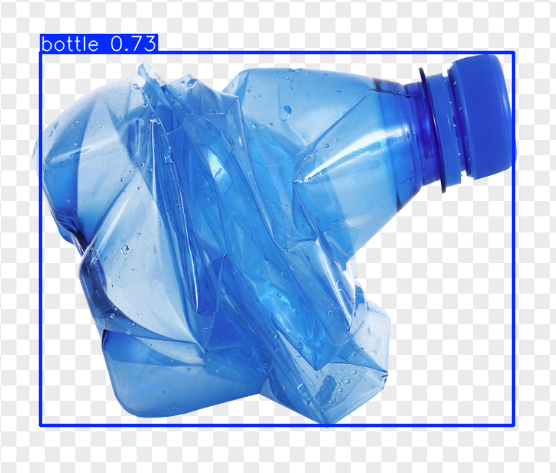

Predictions for /content/drive/MyDrive/crushed.png:
 - Class: bottle, Confidence: 0.73


In [ ]:
def test_model_on_image(image_path):
    model = YOLO('/content/drive/MyDrive/yolov8_training/exp/weights/best.pt')  # Load the trained model
    results = model.predict(image_path, imgsz=IMAGE_SIZE, device="cpu")

    result = results[0]  # Get the first prediction result
    result.show()        # Show the image with predictions

    print(f"Predictions for {image_path}:")
    for box in result.boxes:
        cls_id = int(box.cls[0])
        conf = float(box.conf[0])
        print(f" - Class: {model.names[cls_id]}, Confidence: {conf:.2f}")

test_model_on_image('/content/drive/MyDrive/crushed.png')



image 1/1 /content/drive/MyDrive/bottle.png: 640x576 1 bottle, 235.4ms
Speed: 7.2ms preprocess, 235.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 576)


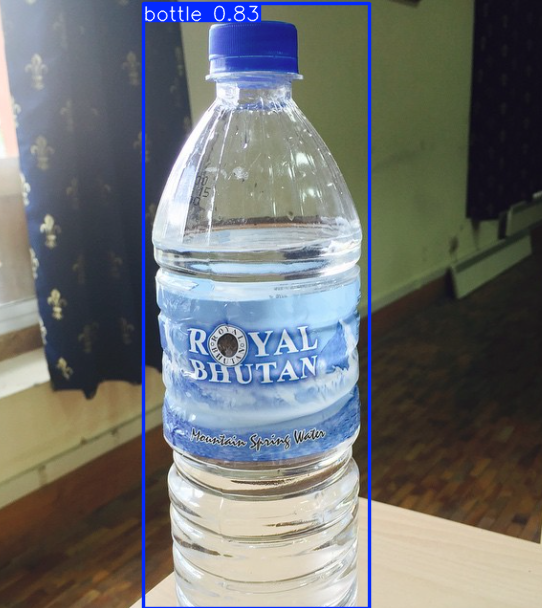

Predictions for /content/drive/MyDrive/bottle.png:
 - Class: bottle, Confidence: 0.83


In [ ]:
def test_model_on_image(image_path):
    model = YOLO('/content/drive/MyDrive/yolov8_training/exp/weights/best.pt')  # Load the trained model
    results = model.predict(image_path, imgsz=IMAGE_SIZE, device="cpu")

    result = results[0]  # Get the first prediction result
    result.show()        # Show the image with predictions

    print(f"Predictions for {image_path}:")
    for box in result.boxes:
        cls_id = int(box.cls[0])
        conf = float(box.conf[0])
        print(f" - Class: {model.names[cls_id]}, Confidence: {conf:.2f}")

test_model_on_image('/content/drive/MyDrive/bottle.png')



image 1/1 /content/drive/MyDrive/Echoes at the Peak.png: 640x576 (no detections), 205.1ms
Speed: 5.3ms preprocess, 205.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


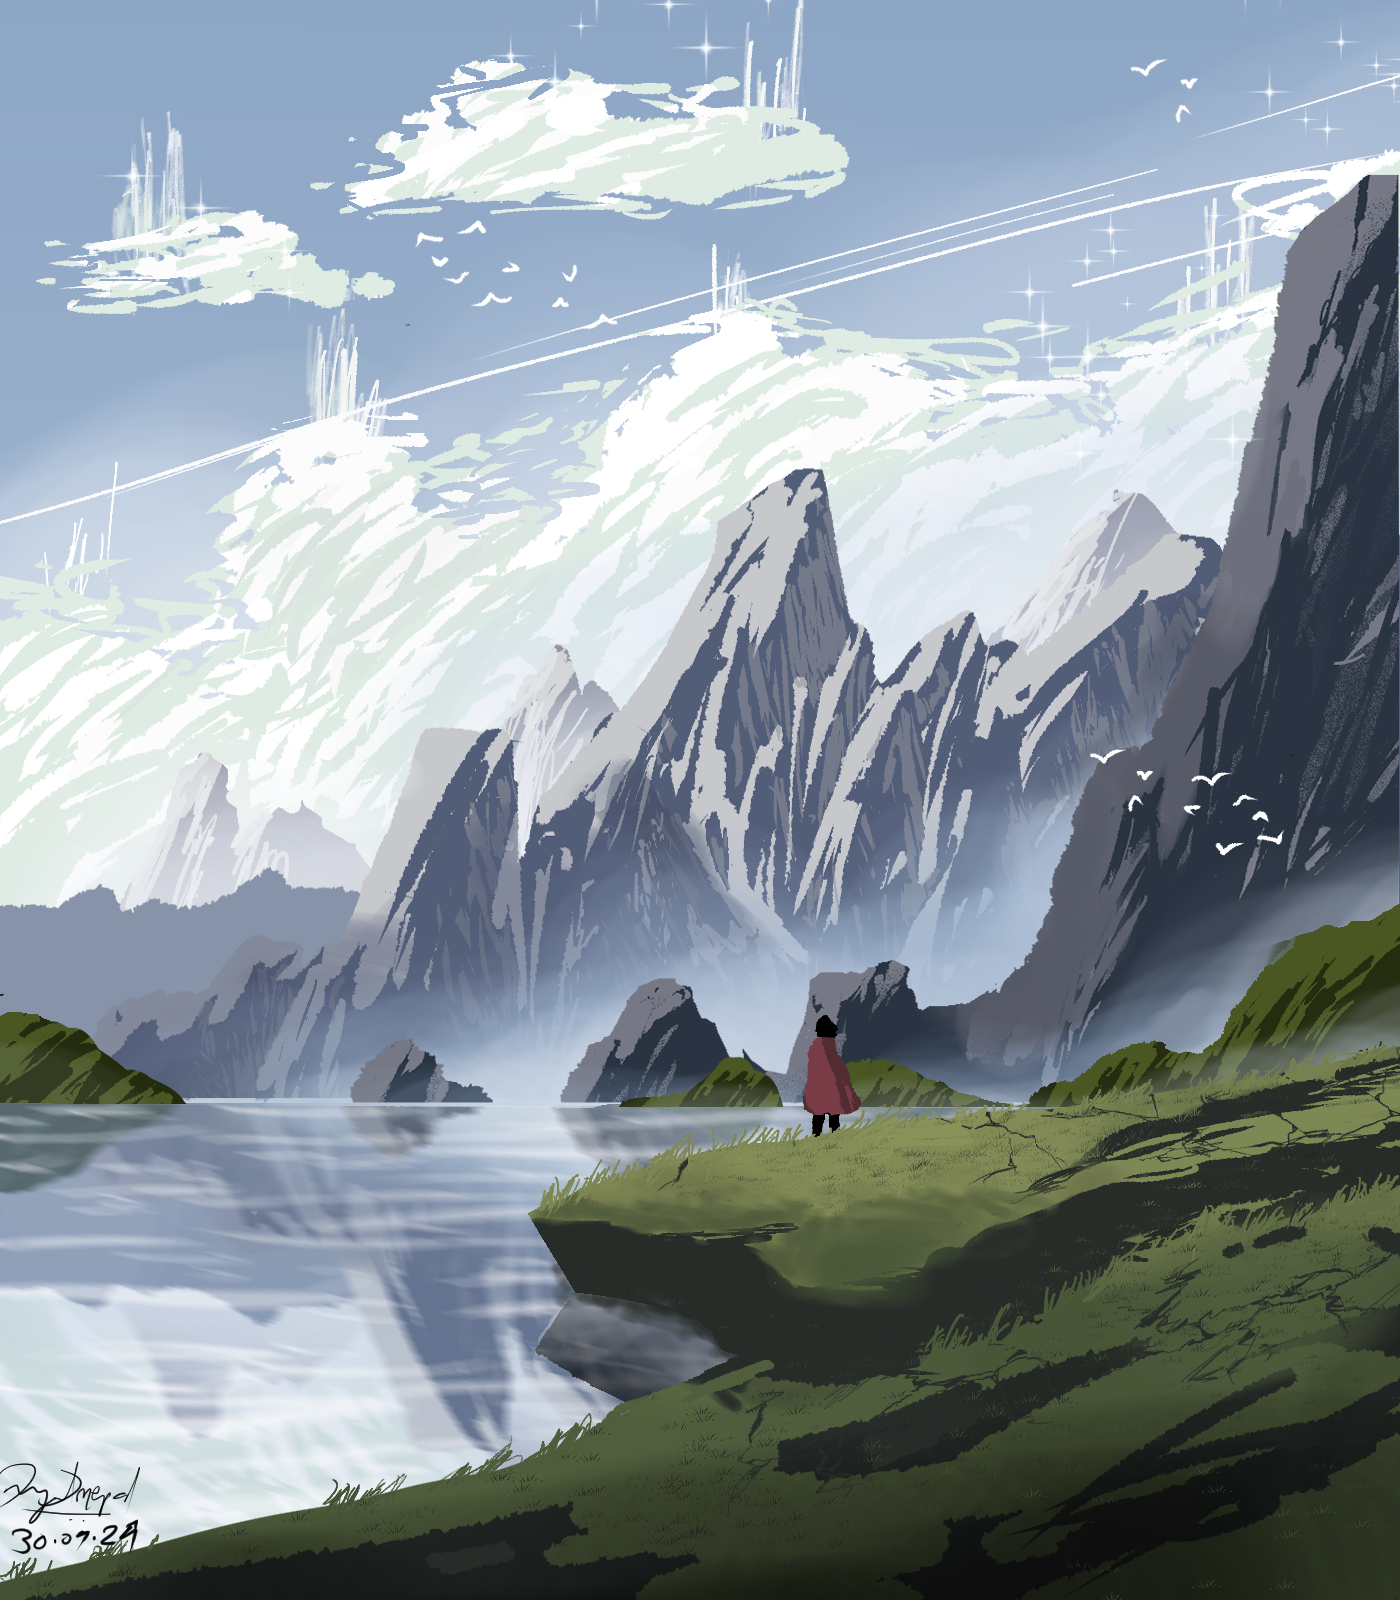

Predictions for /content/drive/MyDrive/Echoes at the Peak.png:


In [ ]:
def test_model_on_image(image_path):
    model = YOLO('/content/drive/MyDrive/yolov8_training/exp/weights/best.pt')  # Load the trained model
    results = model.predict(image_path, imgsz=IMAGE_SIZE, device="cpu")

    result = results[0]  # Get the first prediction result
    result.show()        # Show the image with predictions

    print(f"Predictions for {image_path}:")
    for box in result.boxes:
        cls_id = int(box.cls[0])
        conf = float(box.conf[0])
        print(f" - Class: {model.names[cls_id]}, Confidence: {conf:.2f}")

test_model_on_image('/content/drive/MyDrive/Echoes at the Peak.png')
